<a href="https://colab.research.google.com/github/Shivangierror404/Shivangierror404/blob/main/GAN_for_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())

# Install Torch (optional in Colab)
!pip install torch torchvision --quiet

# Import
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image, make_grid

GPU available: False
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.1 MB/s eta 0:00:00


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flat_img = img.view(img.size(0), -1)
        return self.model(flat_img)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.66MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
latent_dim = 100
epochs = 50
os.makedirs("images", exist_ok=True)

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)

        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch+1}/{epochs} | D loss: {d_loss:.4f} | G loss: {g_loss:.4f}")
    if (epoch + 1) % 10 == 0:
        save_image(gen_imgs.data[:25], f"images/{epoch+1}.png", nrow=5, normalize=True)

Epoch 1/50 | D loss: 0.0087 | G loss: 5.4391
Epoch 2/50 | D loss: 0.0045 | G loss: 5.6519
Epoch 3/50 | D loss: 0.0348 | G loss: 4.5266
Epoch 4/50 | D loss: 0.0138 | G loss: 9.3865
Epoch 5/50 | D loss: 0.0910 | G loss: 3.1683
Epoch 6/50 | D loss: 0.3056 | G loss: 7.4001
Epoch 7/50 | D loss: 0.6132 | G loss: 0.6823
Epoch 8/50 | D loss: 0.2460 | G loss: 4.6433
Epoch 9/50 | D loss: 0.3509 | G loss: 5.1193
Epoch 10/50 | D loss: 0.1614 | G loss: 8.0594
Epoch 11/50 | D loss: 0.1735 | G loss: 2.2070
Epoch 12/50 | D loss: 0.3909 | G loss: 1.4766
Epoch 13/50 | D loss: 0.2948 | G loss: 2.6421
Epoch 14/50 | D loss: 0.3200 | G loss: 1.7255
Epoch 15/50 | D loss: 0.4085 | G loss: 3.2224
Epoch 16/50 | D loss: 0.1986 | G loss: 3.9966
Epoch 17/50 | D loss: 0.3191 | G loss: 2.5788
Epoch 18/50 | D loss: 0.2190 | G loss: 2.5434
Epoch 19/50 | D loss: 0.3177 | G loss: 2.2780
Epoch 20/50 | D loss: 0.3198 | G loss: 2.6524
Epoch 21/50 | D loss: 0.3984 | G loss: 1.9112
Epoch 22/50 | D loss: 0.3681 | G loss: 3.19

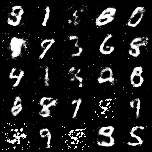

In [ ]:
from PIL import Image
from IPython.display import display
img = Image.open("images/50.png")
display(img)

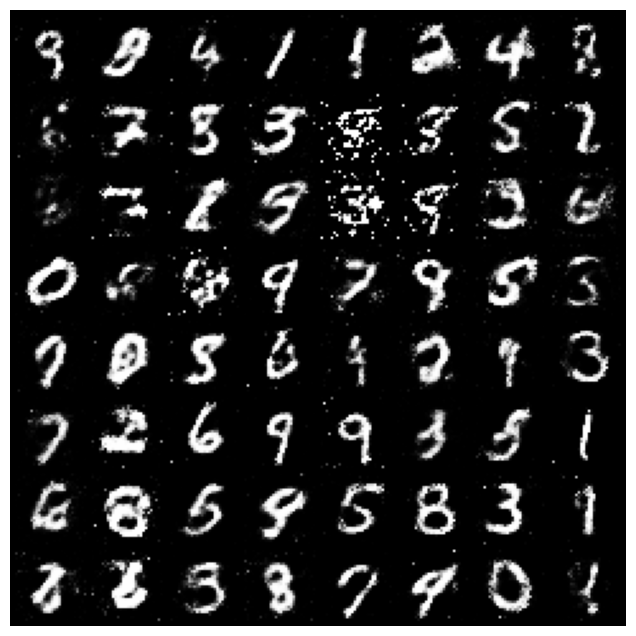

In [ ]:
def generate_and_plot():
    z = torch.randn(64, 100).to(device)
    gen_imgs = generator(z)
    grid = make_grid(gen_imgs, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis("off")
    plt.show()

generate_and_plot()